# Predicting hiraganas

In [1]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from sectioning import obtain_sections, draw_sections, sectionize_image, merge_all_sections, get_section

## Train model

In [2]:
x_train = np.load('model/k49-train-imgs.npz')
y_train = np.load('model/k49-train-labels.npz')

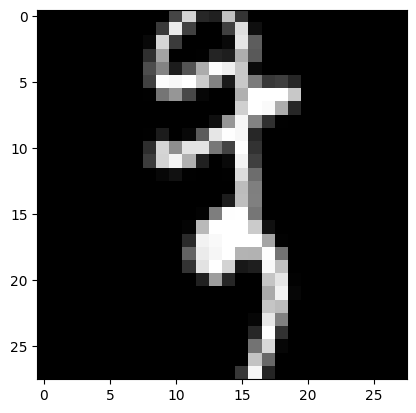

In [3]:
plt.imshow(x_train["arr_0"][0], cmap="grey")
plt.show()

In [4]:
y_train["arr_0"]

array([30, 19, 20, ..., 10, 39, 30], dtype=uint8)

In [5]:
model = keras.saving.load_model("model/kanji_model_350_epochs.hdf5")

## Map class to hiragana

In [6]:
num_classes = 49

In [7]:
def load(f):
    return np.load(f)['arr_0']

In [8]:
# Based on train set
x_img = load('model/k49-train-imgs.npz')
y_class = keras.utils.to_categorical(load('model/k49-train-labels.npz'), num_classes)
y_class = np.argmax(y_class, axis=1)

In [9]:
# Checking the number of classes
y_class_unique = np.unique(y_class)
print(f"All classes represented in the sample: {len(y_class_unique) == num_classes}")

All classes represented in the sample: True


In [10]:
class2unicode = {
    0: "\u3042",
    1: "\u3044",
    2: "\u3046",
    3: "\u3048",
    4: "\u304A",
    5: "\u304B",
    6: "\u304D",
    7: "\u304F",
    8: "\u3051",
    9: "\u3053",
    10: "\u3055",
    11: "\u3057",
    12: "\u3059",
    13: "\u305B",
    14: "\u305D",
    15: "\u305F",
    16: "\u3061",
    17: "\u3064",
    18: "\u3066",
    19: "\u3068",
    20: "\u306A",
    21: "\u306B",
    22: "\u306C",
    23: "\u306D",
    24: "\u306E",
    25: "\u306F",
    26: "\u3072",
    27: "\u3075",
    28: "\u3078",
    29: "\u307B",
    30: "\u307E",
    31: "\u307F",
    32: "\u3080",
    33: "\u3081",
    34: "\u3082",
    35: "\u3084",
    36: "\u3086",
    37: "\u3088",
    38: "\u3089",
    39: "\u308A",
    40: "\u308B",
    41: "\u308C",
    42: "\u308D",
    43: "\u308F",
    44: "\u3090",
    45: "\u3091",
    46: "\u3092",
    47: "\u3093",
    48: "\u309D"
}

In [11]:
map_class2img = {}
for i in range(num_classes):
    idx = np.where(y_class == i)[0][:5]
    map_class2img[i] = x_img[idx]

In [12]:
def class2img(class_number):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i, img in enumerate(map_class2img[class_number]):
        axs[i].imshow(img, cmap="gray")
        axs[i].set_title(f"Example {i+1}")
        axs[i].axis("off")
    fig.suptitle(f"Predicted Hiragana")
    plt.show()

## Predict

### Input

In [13]:
fill_borders = True

In [ ]:
def input_preprocessing(img_name):

    # Load image
    img = cv2.imread("./images/"+img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img[5:60, 25:275]

    plt.imshow(img, cmap="gray")
    plt.title("Original Input Image")
    plt.show()

    # B&W Convertion
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Blurred
    blurred_image = cv2.GaussianBlur(img, (5, 5), 0)

    # Canny
    edges = cv2.Canny(blurred_image, 225, 255)

    if fill_borders:
        # Kernel for morphological operations
        kernel = np.ones((2, 1), np.uint8)
        
        # Morphological closing of gaps
        closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
        
        # Find contours
        contours, _ = cv2.findContours(closed_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Fill
        mask = np.zeros_like(img)
        contours = cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
        
        processed_image = contours

    else:
        processed_image = edges

    plt.imshow(processed_image, cmap="gray")
    plt.title("Preprocessed Image")
    plt.show()

    # Sections
    sections_limits, _ = obtain_sections(processed_image)
    new_sections_limits = merge_all_sections(sections_limits, 2)
    sections = sectionize_image(processed_image, new_sections_limits)

    return processed_image, new_sections_limits, sections

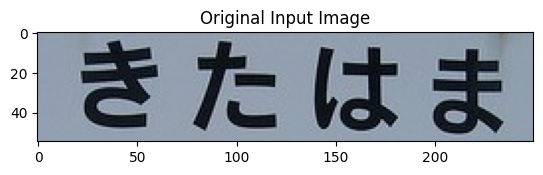

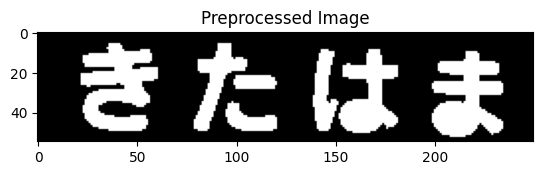

In [15]:
img_name = "kitahama.jpg"
borders_image, section_limits, sections = input_preprocessing(img_name)

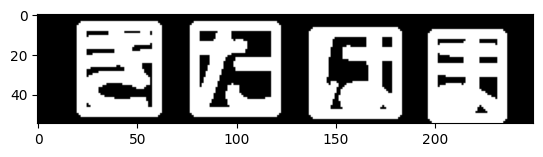

In [16]:
plt.imshow(draw_sections(borders_image, section_limits), cmap="grey")
plt.show()

### Single hiragana prediction

In [17]:
def predict_hiragana(target, show_plot=False):
    section = cv2.resize(target, (28, 28))
    
    if show_plot:
        plt.imshow(section, cmap="grey")
        plt.title("Input")
        plt.axis("off")
        plt.show()

    section = section.astype('float32')
    section /= 255

    predictions = model.predict(np.array([section]))
    prediction = predictions.argmax()

    return prediction

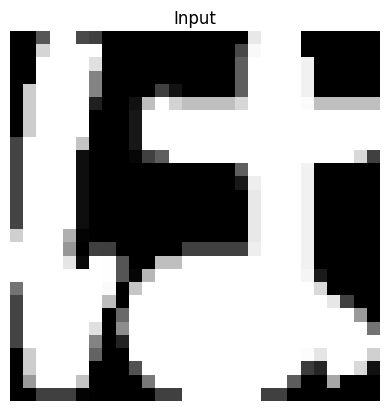

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


### Predicted Hiragana: け

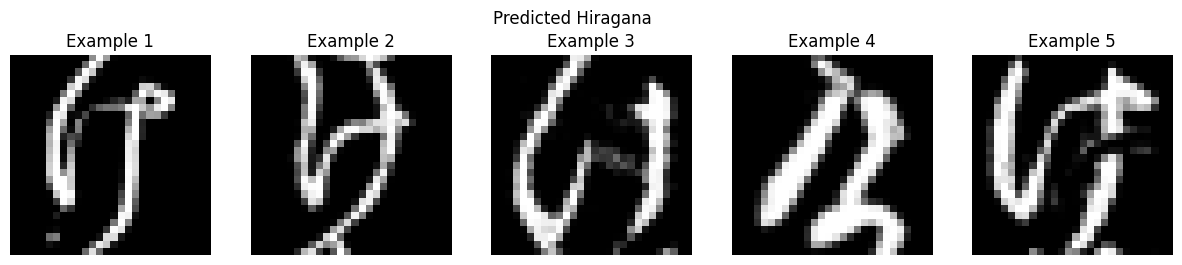

In [18]:
if fill_borders:
    target = sections[2]
else:
    target = sections[1]
prediction = predict_hiragana(target, show_plot=True)
display(Markdown('### Predicted Hiragana: {}'.format(class2unicode[prediction])))
class2img(prediction)

### Word prediction

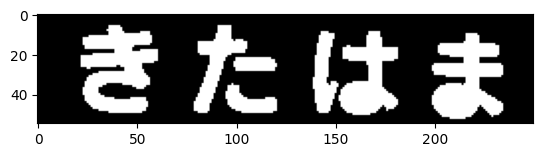

In [19]:
plt.imshow(borders_image, cmap="grey")
plt.show()

In [20]:
selected_row = []

for idx, limits in enumerate(section_limits):
        selected_row.append(idx)
        print(idx, limits)

selected_row = sorted(selected_row, key=lambda idx: section_limits[idx][1][0])
selected_row

0 ((np.int32(6), np.int32(50)), (np.int32(79), np.int32(121)))
1 ((np.int32(10), np.int32(53)), (np.int32(199), np.int32(235)))
2 ((np.int32(9), np.int32(51)), (np.int32(139), np.int32(182)))
3 ((np.int32(6), np.int32(50)), (np.int32(22), np.int32(61)))


[3, 0, 2, 1]

In [21]:
predictions = [class2unicode[x] for x in map(lambda x: predict_hiragana(sections[x]), selected_row)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [22]:
predicted_word = "".join(predictions)
display(Markdown('### Predicted Hiragana word: {}'.format(predicted_word)))

### Predicted Hiragana word: さやけや